#  Predicting Heart Disease based on Cleveland's Dataset

## Introduction

Heart disease is a broad term that encompasses medical conditions that primarily affect coronary arteries, heart rhythm and the health of the heart; some of which are inherited. It is the leading cause of death in the United States, accounting for roughly 1 in every 4 deaths and is notoriously hard to diagnose due to the requirement of several variables needing to simultaneously point towards the same conclusion. Some of the primary factors required in a diagnosis including age, resting (normal) blood pressure, serum cholesterol (level of cholesterol in blood), fasting blood pressure and the maximum heart rate. 

 

The Cleveland Heart Disease Dataset found on the UCI Machine Learning Repository comprises of information on 303 individuals (206 men and 97 women), with an age range of 29 to 77 and 14 variables. Our research question is to assess whether we can create a model that produces the most accurate prediction of the diagnosis of patients using the most relevant variables. The main aim is to have a model that is as accurate as possible given the heavy implications of a misdiagnosis.  

## Preliminary exploratory data analysis:
Demonstrate that the dataset can be read from the web into R.

Clean and wrangle your data into a tidy format.

Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.

Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [11]:
# Loading the libraries.
library(tidyverse)
library(tidymodels)
library(dplyr)
library(readr)
library(cowplot)
library(recipes)
library(RColorBrewer)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


In [12]:
#Loading data into R, selecting interested columns and previewing first 6 rows.
heart <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                  col_names = c("age", "sex", "chestpaintype", "restbps", 
                                "cholesterolserum", "fastingbs", "restecg",
                                "maxheartrate", "exerciseangina", "oldpeak",
                                "slope", "nmajorvessels", "thalassemia", 
                                "diagnosis"))                               %>%
         mutate(diagnosis = as_factor(diagnosis))                           %>%
         select(age, sex, restbps, cholesterolserum, 
                fastingbs, maxheartrate, diagnosis)

head(heart)

#Looking at how many missing values are in each variable:
colSums(is.na(heart))

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  chestpaintype = col_double(),
  restbps = col_double(),
  cholesterolserum = col_double(),
  fastingbs = col_double(),
  restecg = col_double(),
  maxheartrate = col_double(),
  exerciseangina = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  nmajorvessels = col_character(),
  thalassemia = col_character(),
  diagnosis = col_double()
)



age,sex,restbps,cholesterolserum,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,1,150,0
67,1,160,286,0,108,2
67,1,120,229,0,129,1
37,1,130,250,0,187,0
41,0,130,204,0,172,0
56,1,120,236,0,178,0


age              sex          restbps cholesterolserum 
               0                0                0                0 
       fastingbs     maxheartrate        diagnosis 
               0                0                0

In [13]:
# Since values other than 0 for diagnosis means presence of heart disease, 1-4
# values are lumped into 1.Sex and diagnosis factors are also recoded to ease
# understanding of their values and converted into factors for graphing.

heart_disease <- mutate(heart, 
                        diagnosis = fct_lump(diagnosis, other_level = "1")) %>%
                 mutate(sex = recode_factor(sex, `1` = "Male", 
                                                 `0` = "Female" ),
                        diagnosis = recode_factor(diagnosis, `1` = "Yes",
                                                             `0` = "No"),
                        fastingbs = recode_factor(fastingbs, `1` = "Over 120", 
                                                             `0` = "Under 120"))
head(heart_disease)

age,sex,restbps,cholesterolserum,fastingbs,maxheartrate,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
63,Male,145,233,Over 120,150,No
67,Male,160,286,Under 120,108,Yes
67,Male,120,229,Under 120,129,Yes
37,Male,130,250,Under 120,187,No
41,Female,130,204,Under 120,172,No
56,Male,120,236,Under 120,178,No


In [37]:
#Looking at the means/ratio of each predictor for each type of diagnosis.
group_summary <- heart_disease %>% 
  group_by(diagnosis) %>% 
  summarize(size = n(),
            age_mean = mean(age),
            maxheartrate_mean = mean(maxheartrate),
            cholesterolserum_mean = mean(cholesterolserum),
            restbps_mean = mean(restbps),
            sex_fraction_female = sum(sex == "Female")/n(),
            sex_fraction_male = sum(sex == "Male")/n(),
fastingbs_fraction_over_120 = sum(fastingbs == "Over 120")/n(),
fastingbs_fraction_under_120 = sum(fastingbs == "Under 120")/n())
group_summary

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,size,age_mean,maxheartrate_mean,cholesterolserum_mean,restbps_mean,sex_fraction_female,sex_fraction_male,fastingbs_fraction_over_120,fastingbs_fraction_under_120
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Yes,139,56.62590,139.259,251.4748,134.5683,0.1798561,0.8201439,0.1582734,0.8417266
No,164,52.58537,158.378,242.6402,129.2500,0.4390244,0.5609756,0.1402439,0.8597561


In [36]:
#Looking at overall means for numeric predictors.
heart_means <- heart_disease                                                %>%
               select(age, restbps, cholesterolserum, maxheartrate)         %>%
               map_df(mean)
heart_means

age,restbps,cholesterolserum,maxheartrate
<dbl>,<dbl>,<dbl>,<dbl>
54.43894,131.6898,246.6931,149.6073


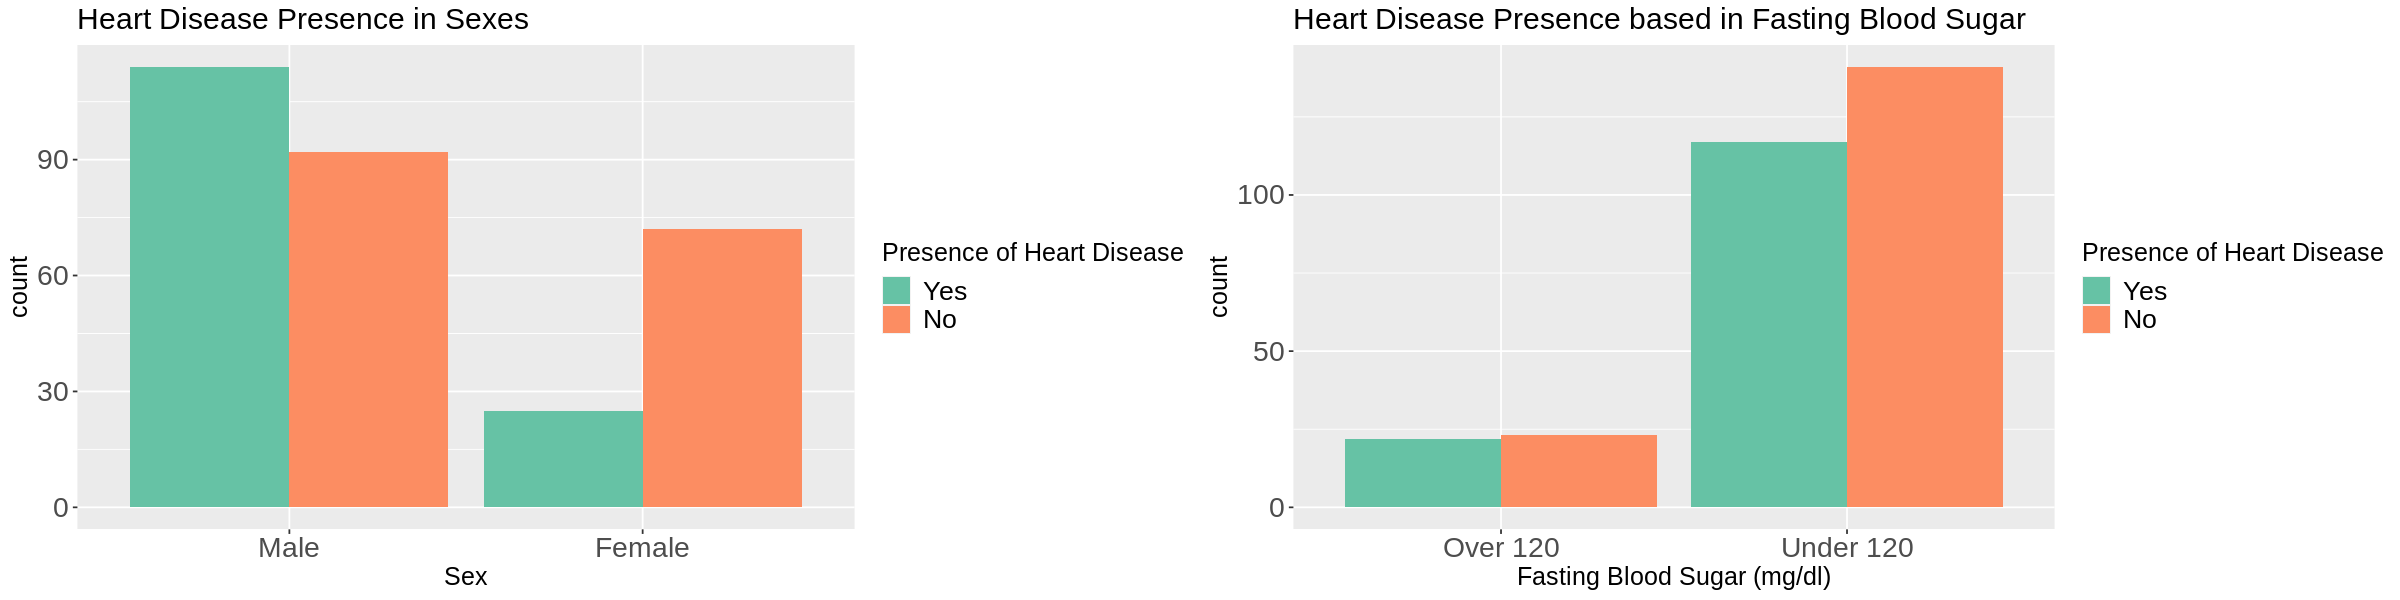

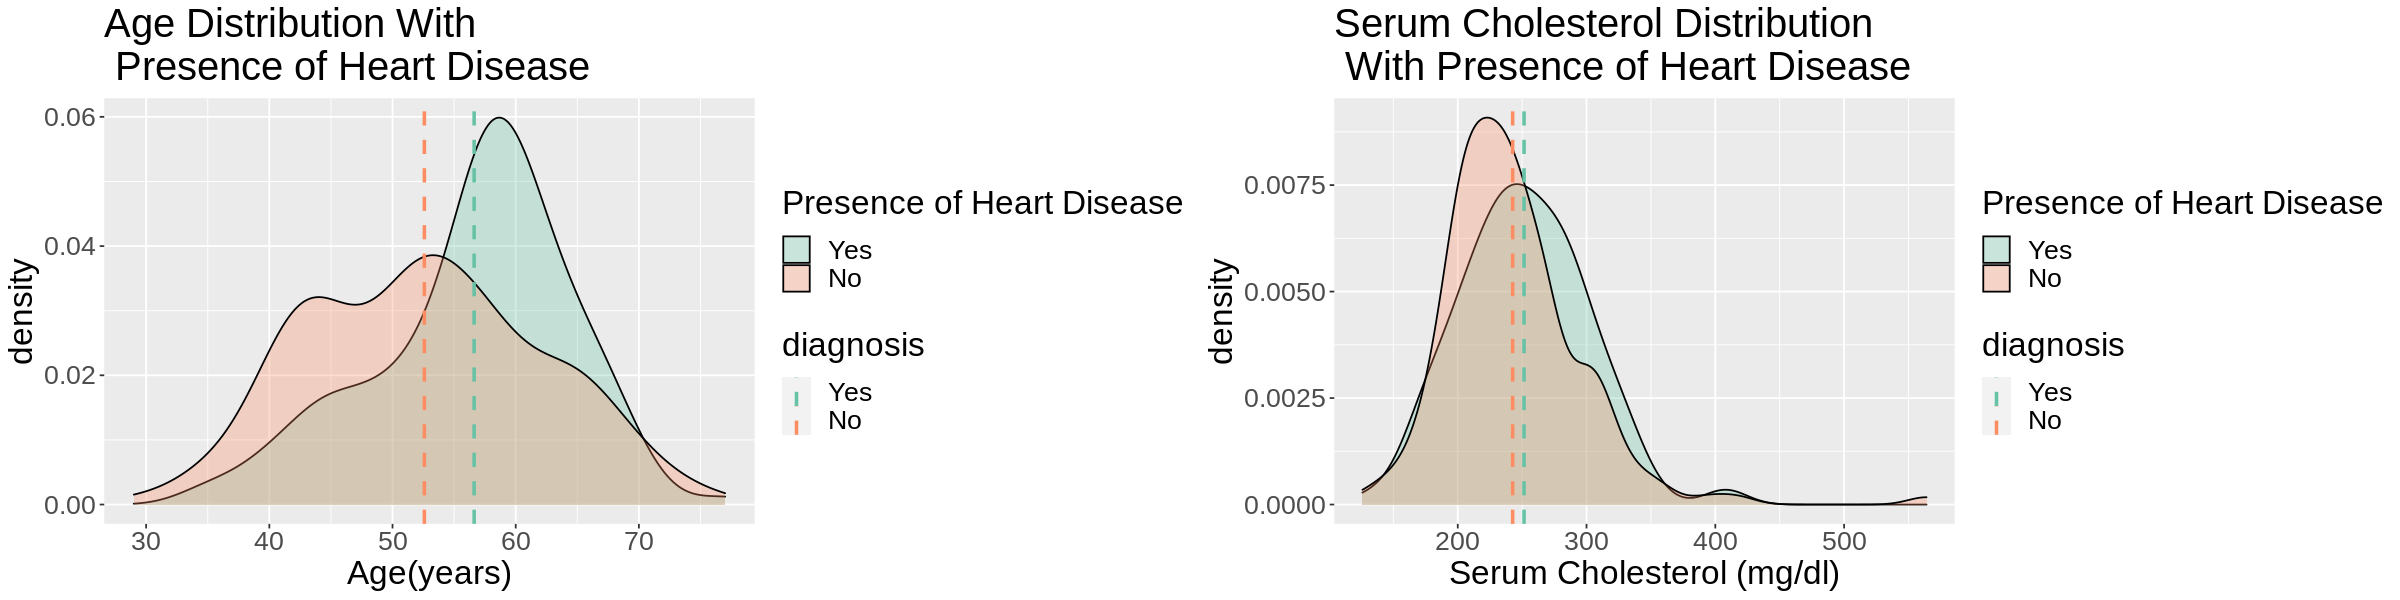

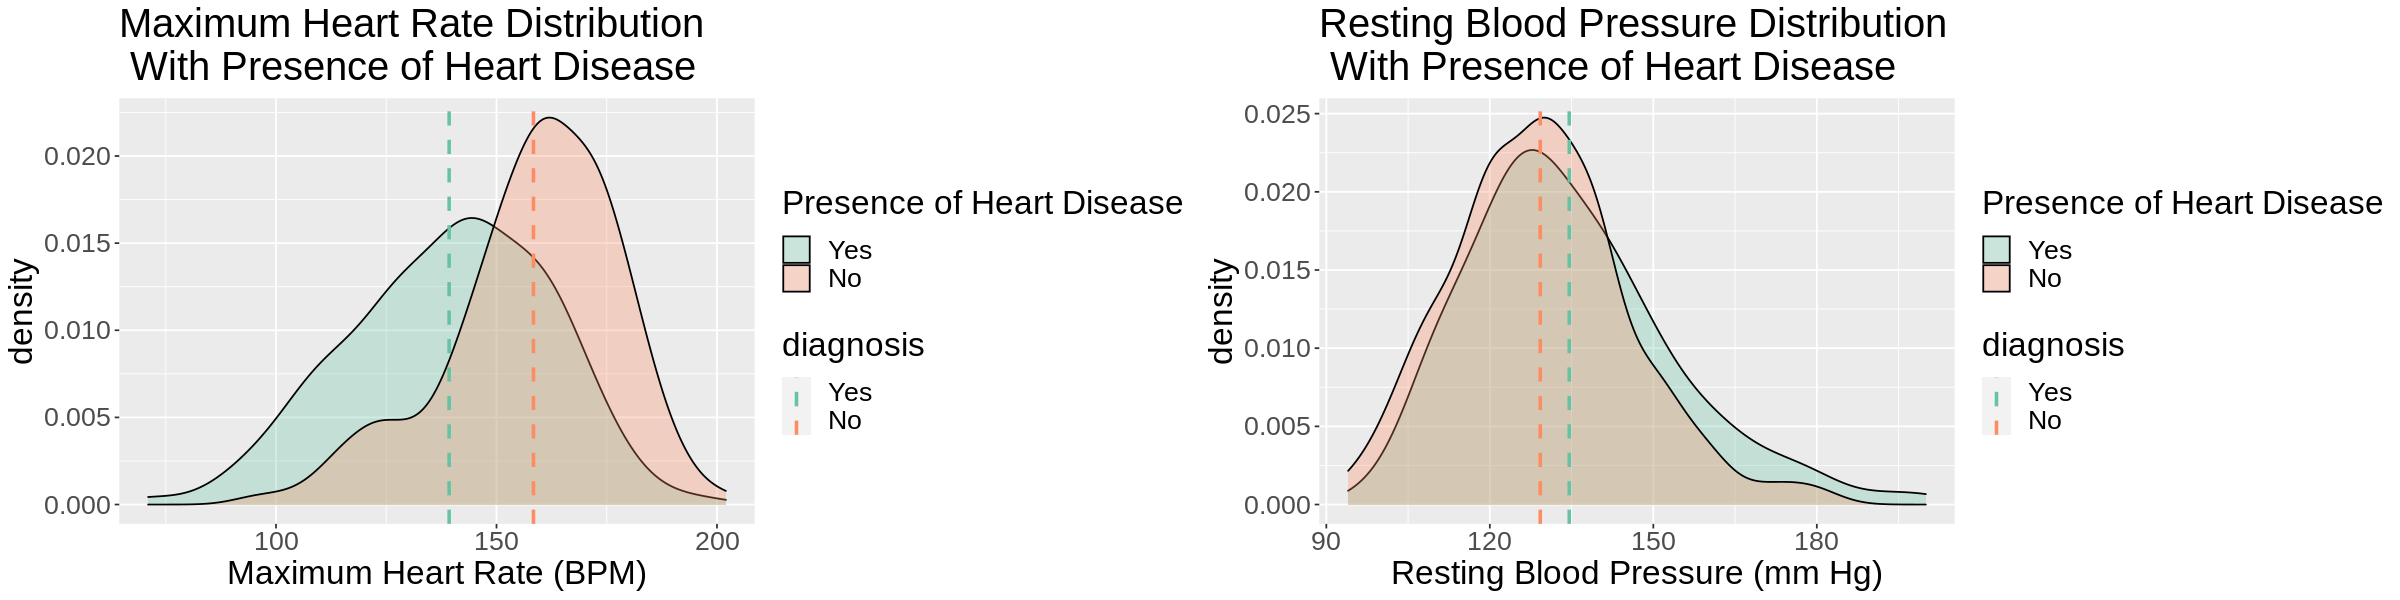

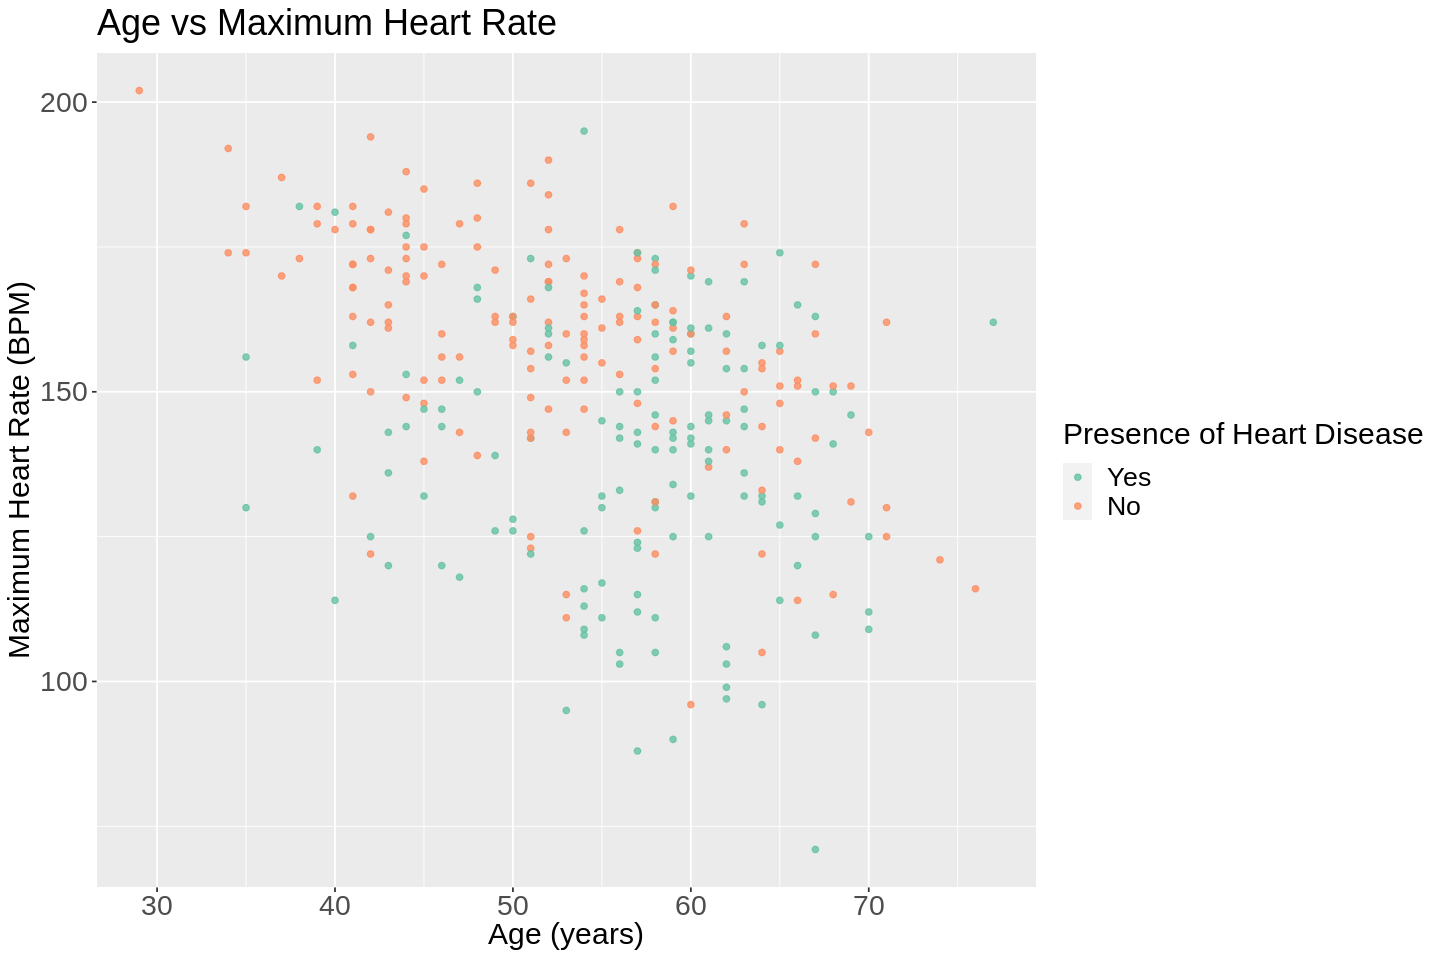

In [61]:
#Visualizing different relevant plots.
options(repr.plot.width = 20, repr.plot.height = 5) 

#Plotting a bar graph looking at presence of heart disease based in the sex.
sex_plot <- ggplot(heart_disease, aes(x = sex, fill = diagnosis))           +
             geom_bar(position = "dodge")                                   +
             labs(x = "Sex", fill = "Presence of Heart Disease")            +
             ggtitle("Heart Disease Presence in Sexes")                     +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

#Plotting a bar graph looking at presence of heart disease based on fasting blood sugar level.
bs_plot  <- ggplot(heart_disease, aes(x = fastingbs, fill = diagnosis))     +
             geom_bar(position = "dodge")                                   +
             labs(x = "Fasting Blood Sugar (mg/dl)", 
                  fill = "Presence of Heart Disease")                       +
             ggtitle("Heart Disease Presence based in Fasting Blood Sugar") +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

#Looking at age distribution
age_plot <- ggplot(heart_disease, aes(x = age, fill = diagnosis)) +
geom_density(alpha = 0.3) +
geom_vline(data = group_summary, aes(xintercept = age_mean, color = diagnosis),
           linetype = "dashed", size = 1) +
labs(x = "Age(years)", fill = "Presence of Heart Disease") +
ggtitle("Age Distribution With \n Presence of Heart Disease") +
theme(text = element_text(size = 20)) +
scale_fill_brewer(palette = "Set2") +
scale_color_brewer(palette = "Set2")

#Looking at serum cholesterol distribution
chol_plot <- ggplot(heart_disease, aes(x = cholesterolserum, fill = diagnosis)) +
geom_density(alpha = 0.3) +
geom_vline(data = group_summary, aes(xintercept = cholesterolserum_mean, color = diagnosis),
 linetype="dashed", size=1) +
labs(x = "Serum Cholesterol (mg/dl)", fill = "Presence of Heart Disease") +
ggtitle("Serum Cholesterol Distribution \n With Presence of Heart Disease") +
theme(text = element_text(size = 20)) +
 scale_fill_brewer(palette = "Set2") +
scale_color_brewer(palette = "Set2")

#Looking at maximum heart rate distribution
heartrate_plot <- ggplot(heart_disease, aes(x = maxheartrate, fill = diagnosis)) +
geom_density(alpha = 0.3)+
geom_vline(data = group_summary, aes(xintercept = maxheartrate_mean, color = diagnosis),
             linetype="dashed", size=1) +
labs(x = "Maximum Heart Rate (BPM)", fill = "Presence of Heart Disease") +
ggtitle("Maximum Heart Rate Distribution \n With Presence of Heart Disease") +
theme(text = element_text(size = 20)) +
 scale_fill_brewer(palette = "Set2") +
scale_color_brewer(palette = "Set2")
      
#Looking at resting blood pressure distribution
bp_plot<- ggplot(heart_disease, aes(x = restbps, fill = diagnosis)) +
geom_density(alpha = 0.3) +
geom_vline(data = group_summary, aes(xintercept = restbps_mean, color = diagnosis),
linetype="dashed", size=1) +
labs(x = "Resting Blood Pressure (mm Hg)", fill = "Presence of Heart Disease") +
ggtitle("Resting Blood Pressure Distribution \n With Presence of Heart Disease") +
theme(text = element_text(size = 20)) +
scale_fill_brewer(palette = "Set2") +
scale_color_brewer(palette = "Set2")
      
plot_grid(sex_plot, bs_plot, ncol = 2)
plot_grid(age_plot, chol_plot, ncol = 2)
plot_grid(heartrate_plot, bp_plot, ncol = 2)

#Plotting a scatter plot with Age vs Maximum Heart Rate
age_heart <- ggplot(heart_disease, aes(x = age, y = maxheartrate, 
                                       color = diagnosis))                  +
              geom_point(alpha = 0.8)                                       +
              labs(x = "Age (years)", y = "Maximum Heart Rate (BPM)", 
                   color = "Presence of Heart Disease")                     +
              ggtitle("Age vs Maximum Heart Rate")                          +
              theme(text = element_text(size = 20),
                    axis.text.x = element_text(size = 17),
                    axis.text.y = element_text(size = 17),
                    title       = element_text(size = 18))                  +
              scale_color_brewer(palette = "Set2")

options(repr.plot.width = 12, repr.plot.height = 8)
age_heart

## Expected Outcomes & Their Significance

We would like to derive from this data is what factors have the heaviest say in determining the diagnosis of heart disease. As current research shows, men are more prone to being diagnosed with a heart disease, we would also like to assess whether this hypothesis proves true in our data. Going a step further, it will be important to know why men are more susceptible to the leading factors that end in heart in disease to see what could be done about it. This depends however on whether it is genetic, and thus not much can be done about it, or whether is cultural, such as higher mean alcohol and drug consumption. 